In [1]:
import os
from pathlib import Path
from typing import List


BASE = Path("/home/timgarrels/Projects/masterthesis/copied_results_data/benchmark_logfiles")

dirs = os.listdir(BASE)
RANDOM_GRAPHS = 50


def extract_dataset_names(dirs: List[str]):
    datasets = []
    for d in dirs:
        bench, version, *parts = d.split("_")
        datasets.append("_".join(parts))
    return set(datasets)

DATASETS = extract_dataset_names(dirs)
DATASETS.remove("kaggle_so_tags")
DATASETS.remove("kaggle_star_wars")

In [2]:
DATASETS.remove("0_scale_free_graph_a_28_b_7_g_02")
DATASETS.remove("1_scale_free_graph_a_28_b_7_g_02")
DATASETS.remove("2_scale_free_graph_a_28_b_7_g_02")
DATASETS.remove("3_scale_free_graph_a_28_b_7_g_02")
DATASETS.remove("4_scale_free_graph_a_28_b_7_g_02")

DATASETS.remove("human_brain_development_cutoff_0.772")
DATASETS.remove("human_cancer_cutoff_0.935")
DATASETS.remove("yeastInter_st")

In [3]:
def get_benchmark_log(dataset: str, k: int, version: int):
    """Returns the path to the logfile specified by the given parameters"""
    assert dataset in DATASETS, "no such dataset"
    assert k in [3,4], "not a valid graphlet size"
    assert version in range(1, 6), "not a valid version"
    
    prefix = f"bench_{version}"
    
    graph_count = RANDOM_GRAPHS if k == 3 else -1 # Graph
    
    d = BASE / Path(f"{prefix}_{dataset}")
    path = d / f"{version}_{dataset}_{k}_{graph_count}.benchmark"
    return path

In [4]:
def parse_benchmark_log(logfile: Path):
    with open(logfile, "r") as f:
        lines = []
        for l in f:
            info_index = l.index("INFO")
            cut = info_index + len("INFO") + 1
            lines.append(l[cut:])
    
    logs = {}
    for l in lines:
        name, time = l.split(":")
        if name == "Random Creation Runtime":
            time, *note = time.strip().split(" ")
        logs[name] = float(time)
    return logs

In [5]:
from typing import Dict
from statistics import mean


def refine_benchmark_data(data: Dict):
    
    random_gtrie_runtimes = [
        data[f"Random {r}, graphlet_runtime"]
        for r in range(RANDOM_GRAPHS)
    ]
    random_metric_runtimes = [
        data[f"Random {r}, metric_runtime"]
        for r in range(RANDOM_GRAPHS)
    ]
    
    return {
        "total_runtime": data["Total Runtime"],
        "original_gtrie_runtime": data["graphlet_runtime"],
        "original_metric_runtime": data["metric_runtime"],
        "random_generation_runtime": data["Random Creation Runtime"],
        "random_gtrie_runtimes": random_gtrie_runtimes,
        "random_metric_runtimes": random_metric_runtimes,
    }

In [6]:
import pandas as pd


def avg_benchmark_runs(dataset: str, k: int):
    """Returns the means of datapoints over the five versions"""
    
    refined_data_colelction = []
    for v in [1,2,3,4,5]:
        p = get_benchmark_log(dataset, k, v)
        data = parse_benchmark_log(p)
        refined = refine_benchmark_data(data)
        refined_data_colelction.append(refined)
    df = pd.DataFrame(refined_data_colelction)
    
    df["avg random_gtrie_runtimes"] = df["random_gtrie_runtimes"].apply(mean)
    df["total random_gtrie_runtimes"] = df["random_gtrie_runtimes"].apply(sum)
    del df["random_gtrie_runtimes"]
    df["avg random_metric_runtimes"] = df["random_metric_runtimes"].apply(mean)
    df["total random_metric_runtimes"] = df["random_metric_runtimes"].apply(sum)
    del df["random_metric_runtimes"]
    
    return dict(df.mean())

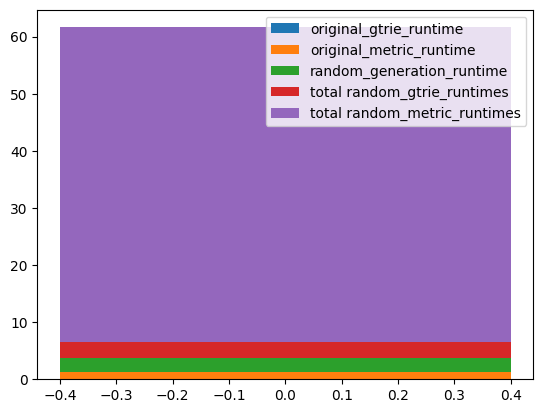

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

data = avg_benchmark_runs("0_barabasi_albert_graph_m_1", 3)
del data["total_runtime"]
del data["avg random_gtrie_runtimes"]
del data["avg random_metric_runtimes"]

bottom = 0
for k, value in data.items():
    ax.bar(0, value, label=k, bottom=bottom)
    bottom += value
ax.legend()

In [8]:
"""Colelct Subgraph Counts to put context to runtimes"""
from tqdm import tqdm
import pandas as pd
from pathlib import Path

out4 = Path("../subgraph_size_4_counts.csv")
counts_df_4 = pd.read_csv(out4)
counts_df_4 = counts_df_4.set_index("Graph")

counts_df_4.at["human_cancer_cutoff_0.935", "Subgraph Count"] = 360658 + 338973 + 159215 + 24031 + 6799 + 3806
counts_df_4.at["human_brain_development_cutoff_0.772", "Subgraph Count"] = 252358 + 234582 + 109178 + 12972 + 4055 + 3196

out3 = Path("../subgraph_size_3_counts.csv")
counts_df_3 = pd.read_csv(out3)
counts_df_3 = counts_df_3.set_index("Graph")

counts_df_3.at["human_cancer_cutoff_0.935", "Subgraph Count"] = 32903 + 3437
counts_df_3.at["human_brain_development_cutoff_0.772", "Subgraph Count"] = 25155 + 2977

In [9]:
from statistics import stdev, mean


def get_dataframe(k: int):
    rows = []
    for dataset in DATASETS:
        try:
            data = avg_benchmark_runs(dataset, k)
            data["dataset"] = dataset
            data["subgraph_count_3"] = counts_df_3.at[dataset, "Subgraph Count"]
            data["subgraph_count_4"] = counts_df_4.at[dataset, "Subgraph Count"]
            rows.append(data)
        except KeyError as e:
            print(dataset, e)
            continue

    df = pd.DataFrame(rows).set_index("dataset")
    return df

mi_me_ma = lambda x: (min(x), mean(x), max(x), stdev(x))

In [10]:
def percent_original_random(k, ax=None):
    df = get_dataframe(k)

    df["Original"] = (df["original_gtrie_runtime"] + df["original_metric_runtime"]) / df["total_runtime"]
    df["Random"] = (df["total random_gtrie_runtimes"] + df["total random_metric_runtimes"]) / df["total_runtime"]
    df["Randomization"] = (df["random_generation_runtime"]) / df["total_runtime"]
    df = df[["Original", "Random", "Randomization"]]
    return df.apply(mi_me_ma), df[["Randomization", "Original", "Random"]].plot.box(
        title=f"${k}$-Graphlets",
        ax=ax
    )

   Original    Random  Randomization
0  0.017746  0.938564       0.011278
1  0.019455  0.957270       0.022866
2  0.022939  0.970220       0.038640
3  0.001681  0.009800       0.008120
   Original    Random  Randomization
0  0.018069  0.961791       0.000002
1  0.021402  0.978528       0.000021
2  0.038073  0.981903       0.000105
3  0.005553  0.005556       0.000021


/tmp/ipykernel_6818/2904866205.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


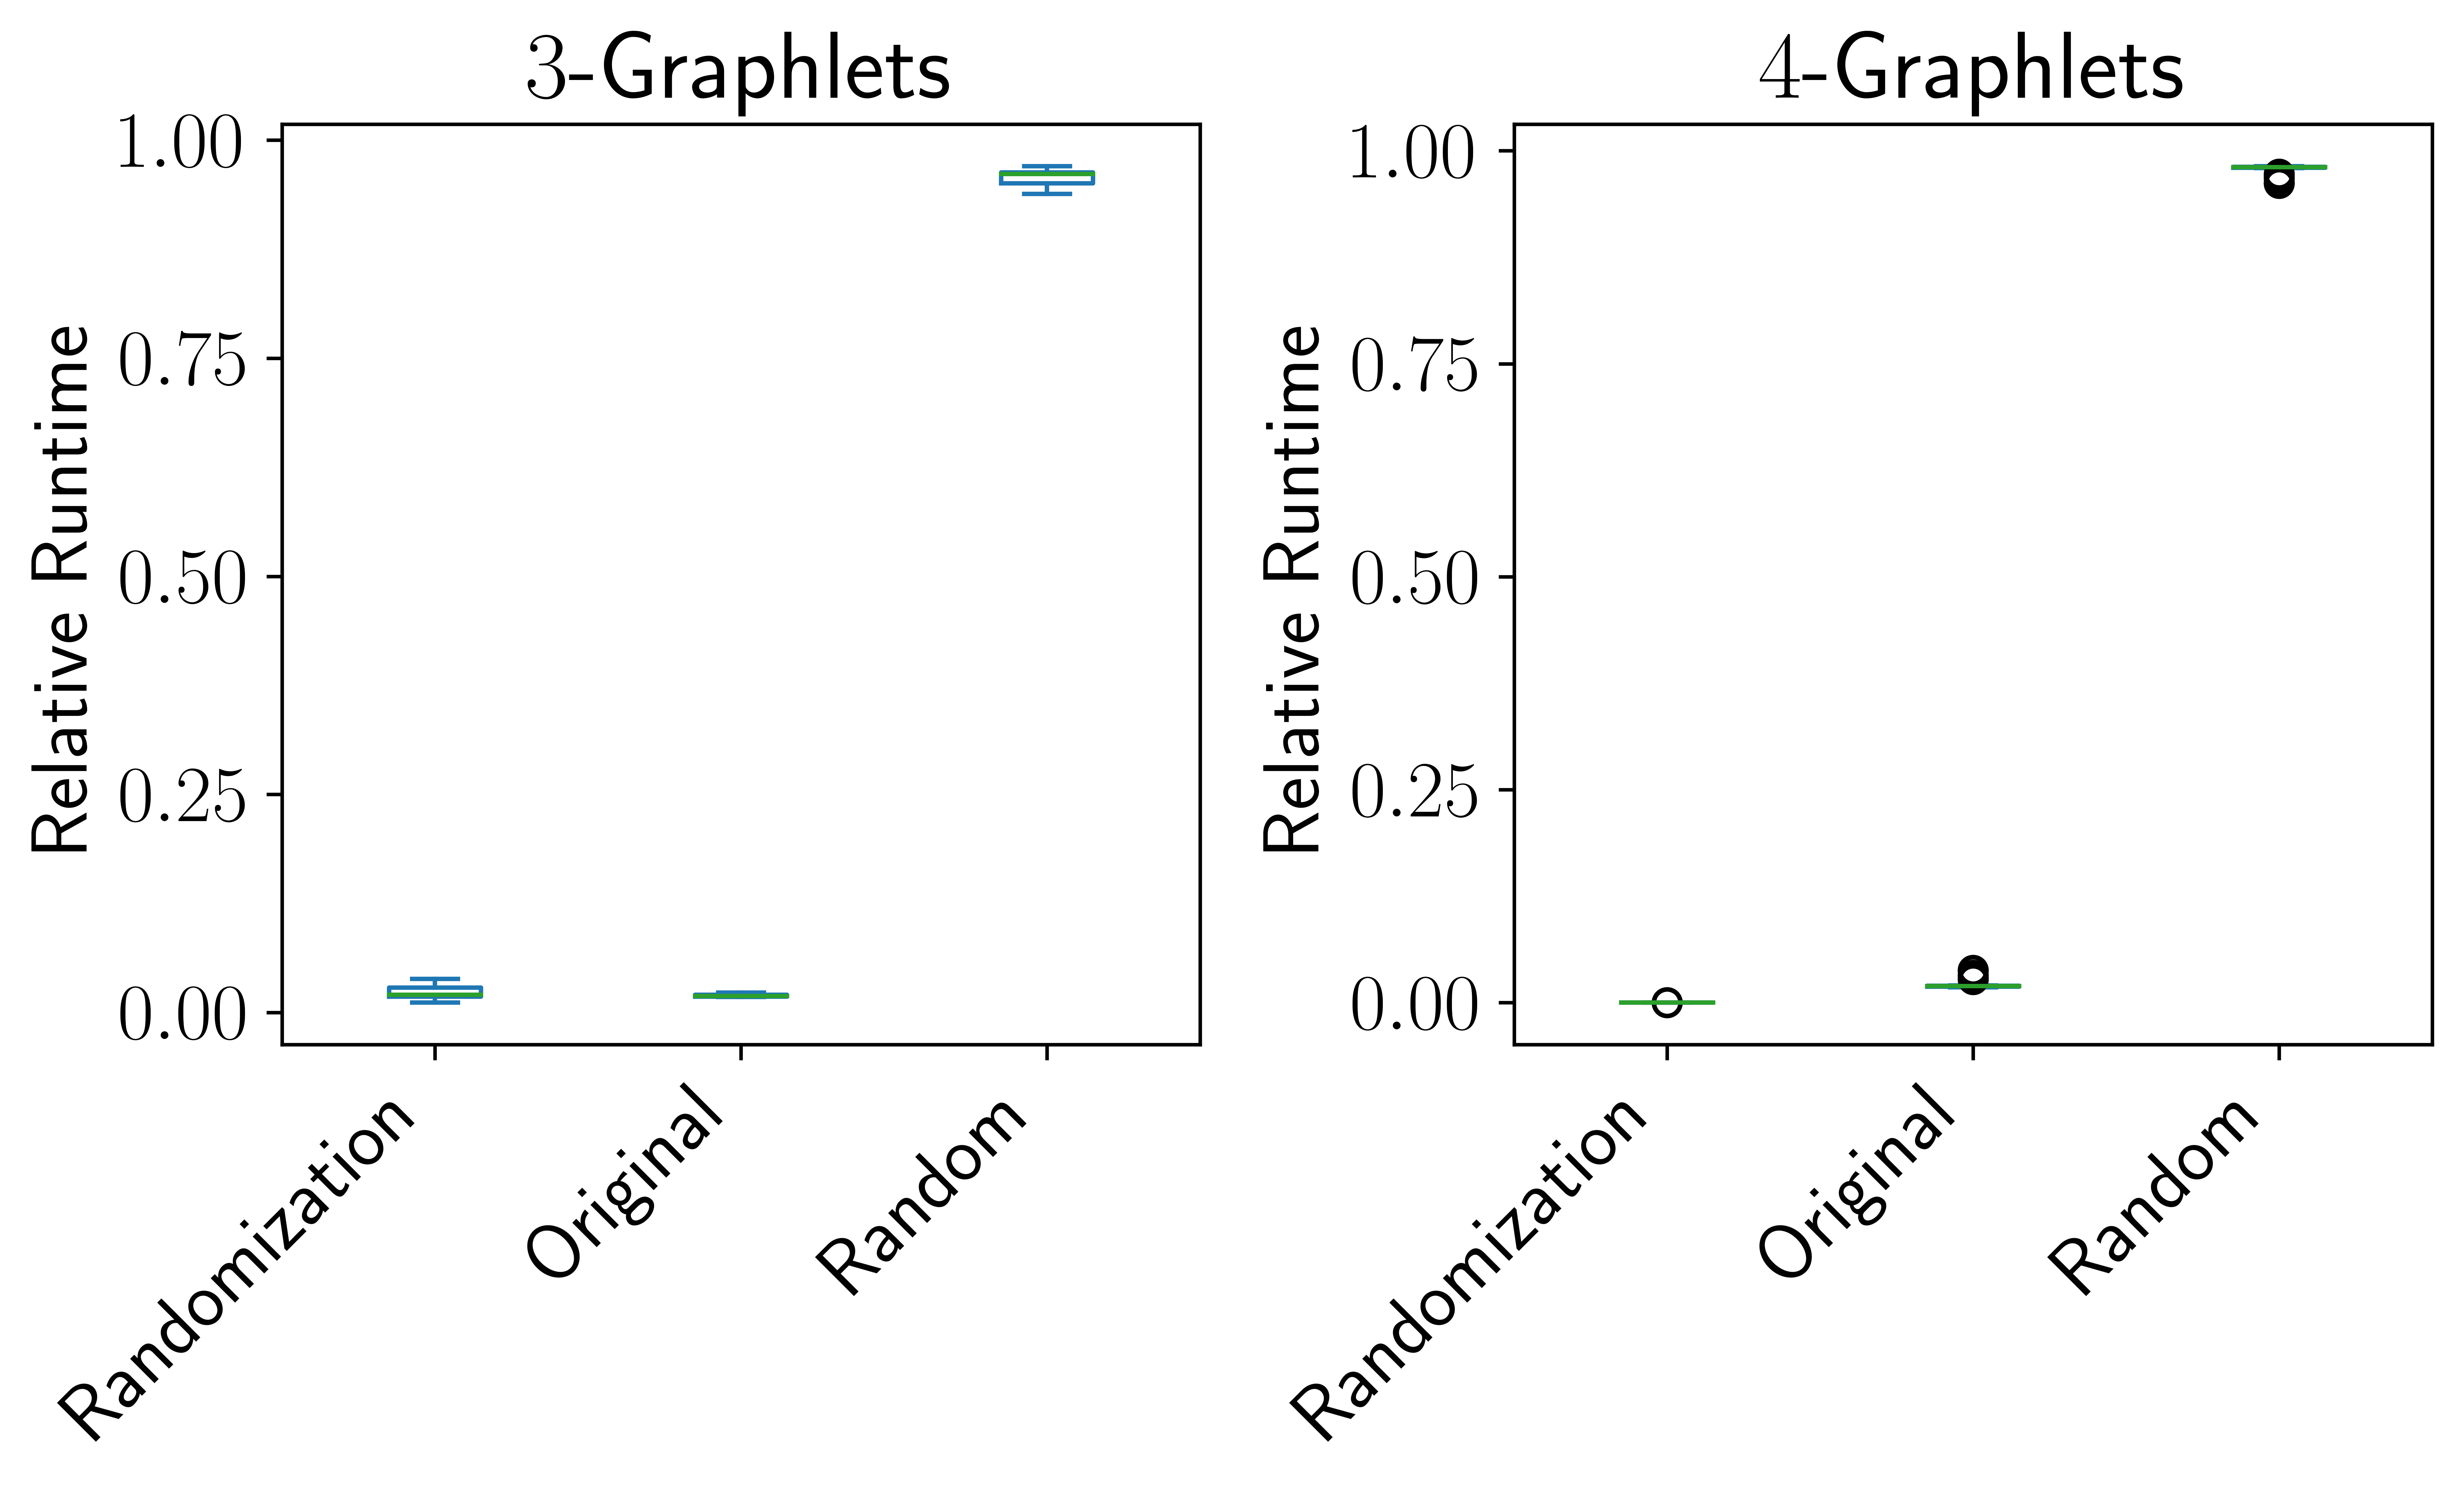

In [11]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(8,5), dpi=1024)

print(percent_original_random(3, ax3)[0])
print(percent_original_random(4, ax4)[0])

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha="right")
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha="right")

ax3.set_ylabel("Relative Runtime")
ax4.set_ylabel("Relative Runtime")

fig.tight_layout()
fig.show()

In [87]:
def percent_motif_pmotif(k, ax=None):
    df = get_dataframe(k)
    df["Graphlet\nDetection"] = (df["original_gtrie_runtime"] + df["total random_gtrie_runtimes"]) / df["total_runtime"]
    df[r"\textsc{p-metric} Collection"] = (df["original_metric_runtime"] + df["total random_metric_runtimes"]) / df["total_runtime"]
    df["Randomization"] = (df["random_generation_runtime"]) / df["total_runtime"]
    df = df[["Randomization", "Graphlet\nDetection", r"\textsc{p-metric} Collection"]]
    return df.apply(mi_me_ma), df[["Randomization", "Graphlet\nDetection", r"\textsc{p-metric} Collection"]].plot.box(
        title=f"${k}$-Graphlets",
        ax=ax,
    )

   Randomization  Graphlet\nDetection  \textsc{p-metric} Collection
0       0.011278             0.020988                      0.907164
1       0.022866             0.044545                      0.932180
2       0.038640             0.056714                      0.960056
3       0.008120             0.011672                      0.017281
   Randomization  Graphlet\nDetection  \textsc{p-metric} Collection
0       0.000002             0.025742                      0.932498
1       0.000021             0.051404                      0.948526
2       0.000105             0.067440                      0.974185
3       0.000021             0.013590                      0.013592


/tmp/ipykernel_6818/1417919493.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


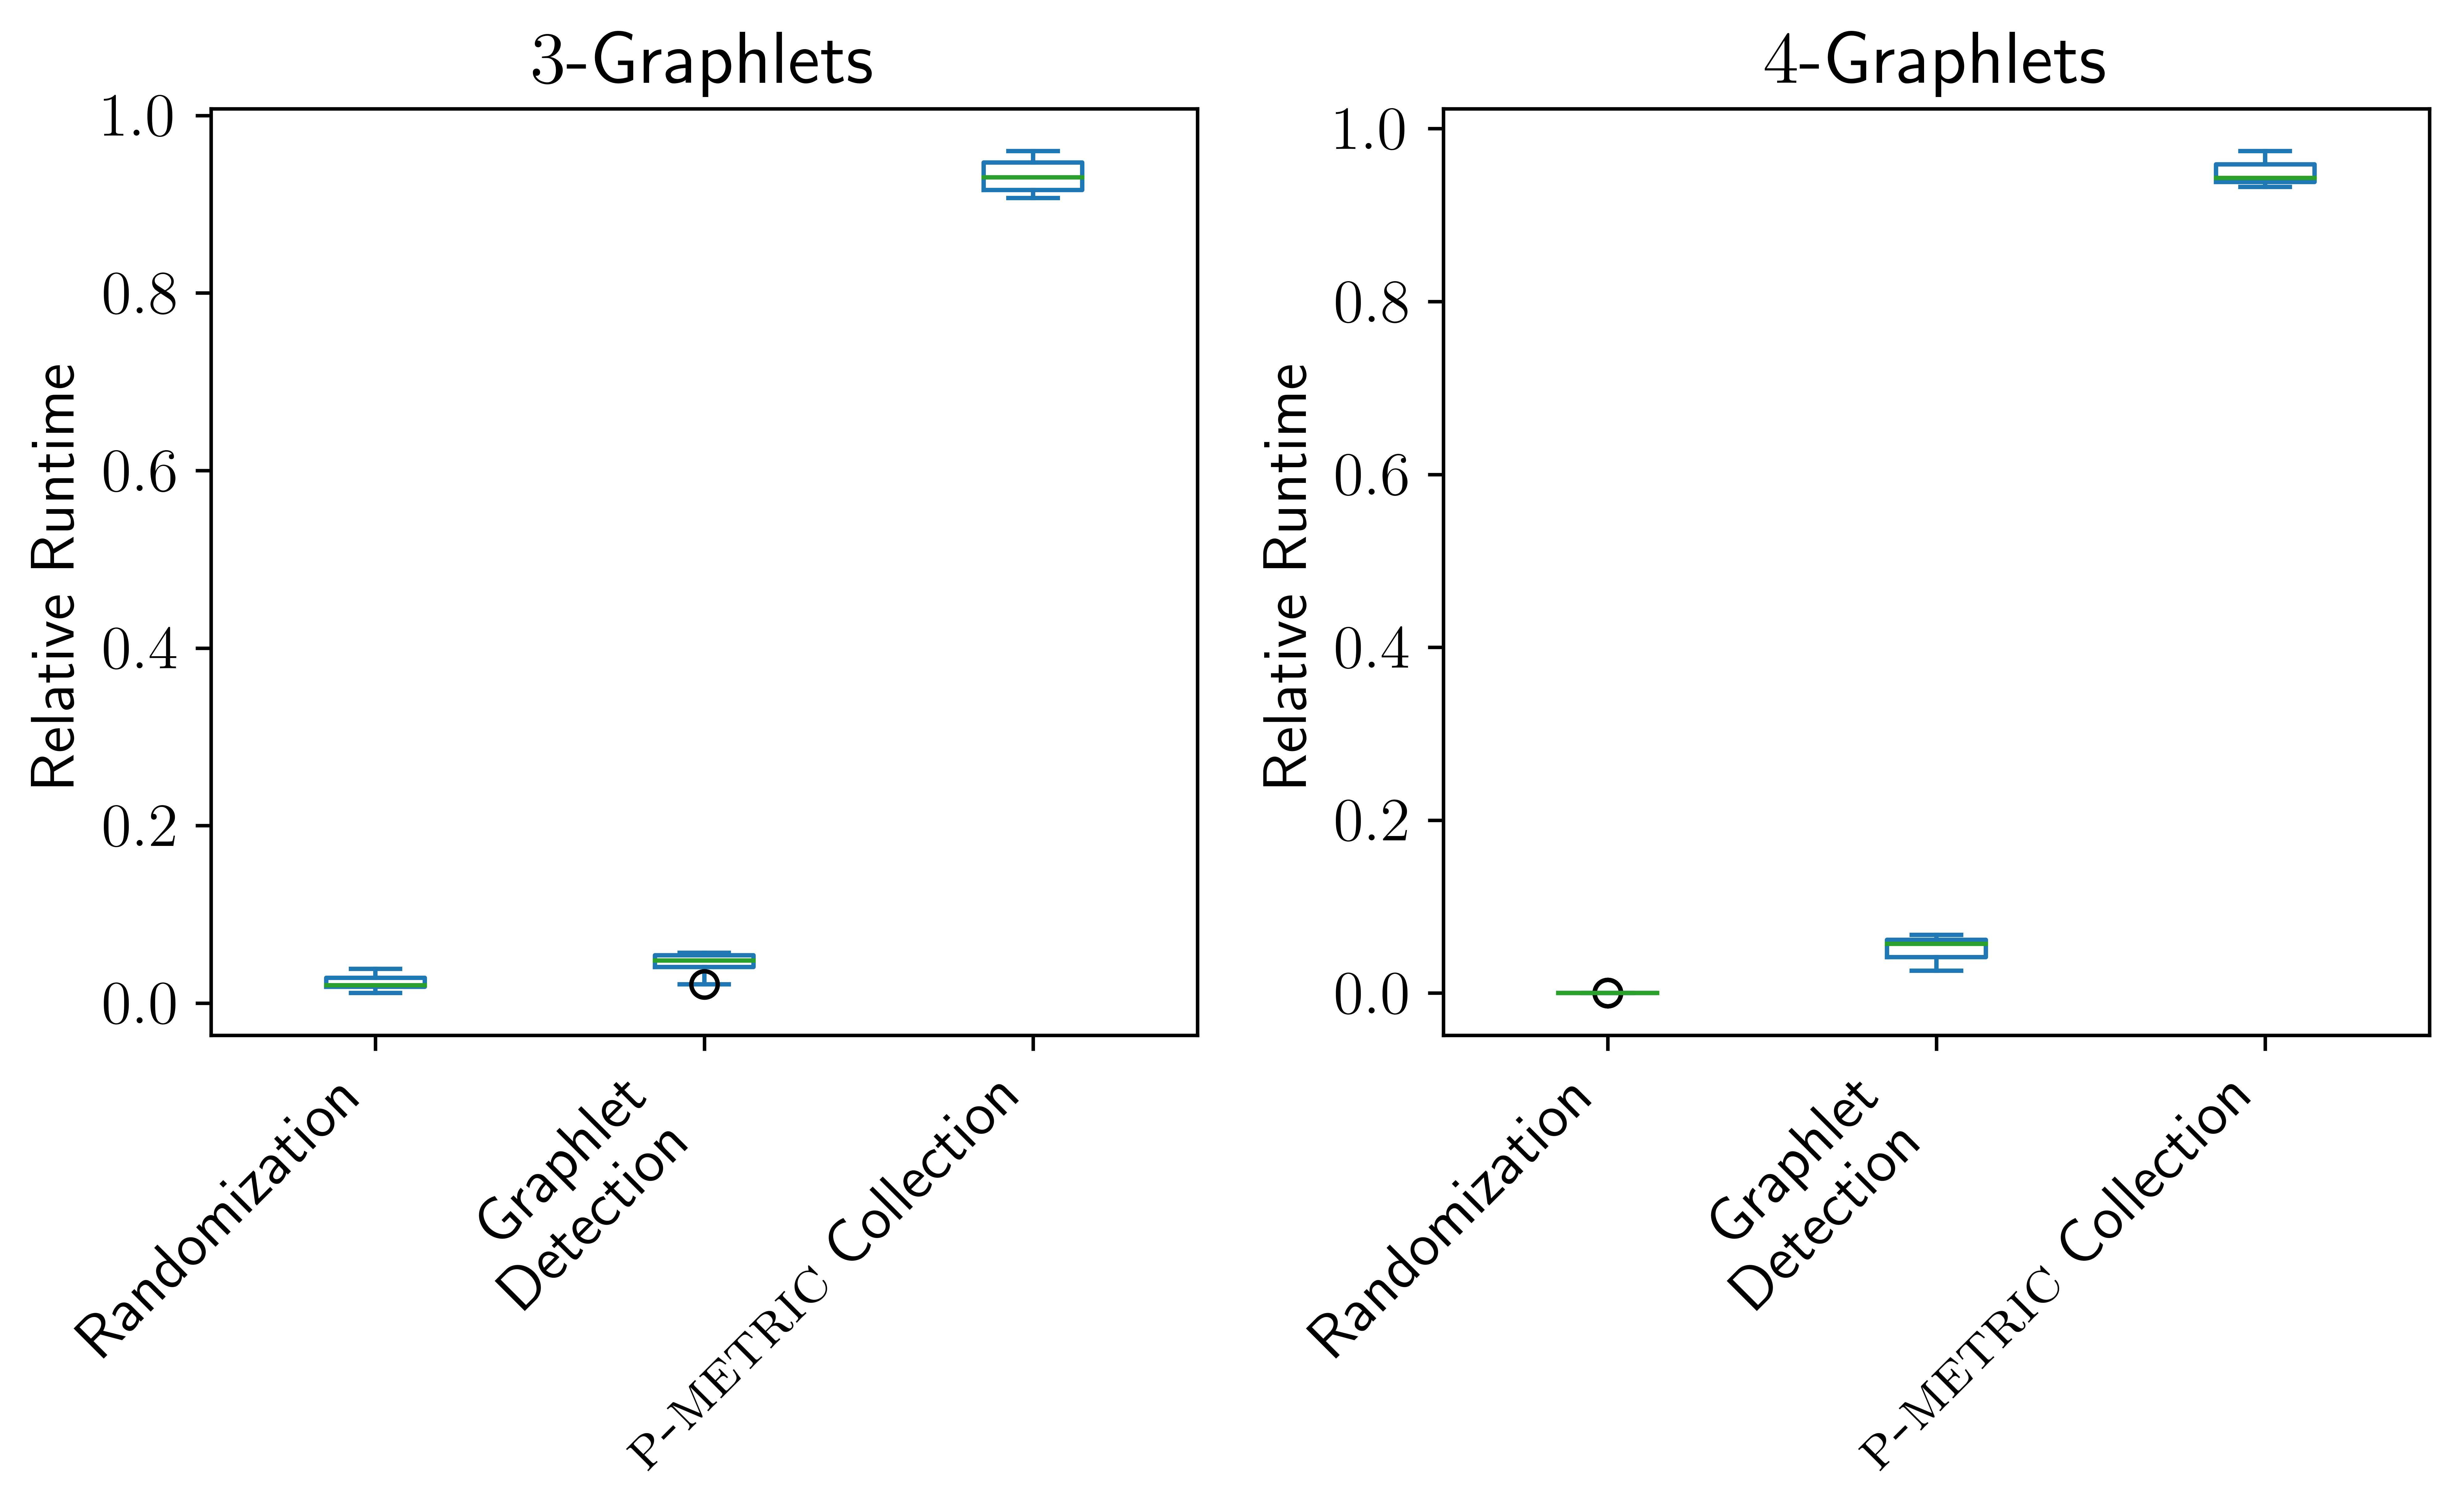

In [88]:

plt.rcParams.update({'font.size': 14})
plt.rcParams['text.usetex'] = True


fig, (ax3, ax4) = plt.subplots(1,2, figsize=(8,5), dpi=1024)

print(percent_motif_pmotif(3, ax3)[0])
print(percent_motif_pmotif(4, ax4)[0])

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha="right")
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha="right")


ax3.set_ylabel("Relative Runtime")
ax4.set_ylabel("Relative Runtime")

fig.tight_layout()
fig.show()

In [14]:
fig.savefig("runtime_distribution.pdf")
fig.savefig("runtime_distribution.png")

In [15]:
def all_percent(k, ax=None):
    df = get_dataframe(k)
    df["Original Graphlet"] = df["original_gtrie_runtime"] / df["total_runtime"]
    df[r"Original \textsc{p-metric}"] = df["original_metric_runtime"] / df["total_runtime"]
    df["Randomization"] = df["random_generation_runtime"] / df["total_runtime"]
    df["Random Graphlet"] = df["total random_gtrie_runtimes"] / df["total_runtime"]
    df[r"Random \textsc{p-metric}"] = df["total random_metric_runtimes"] / df["total_runtime"]
    
    df = df[[
        "Original Graphlet",
        r"Original \textsc{p-metric}",
        "Randomization",
        "Random Graphlet",
        r"Random \textsc{p-metric}",
    ]]
    return df.plot.box(
        title=f"${k}$-Graphlets",
        ax=ax,
    )

/tmp/ipykernel_6818/2838267959.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


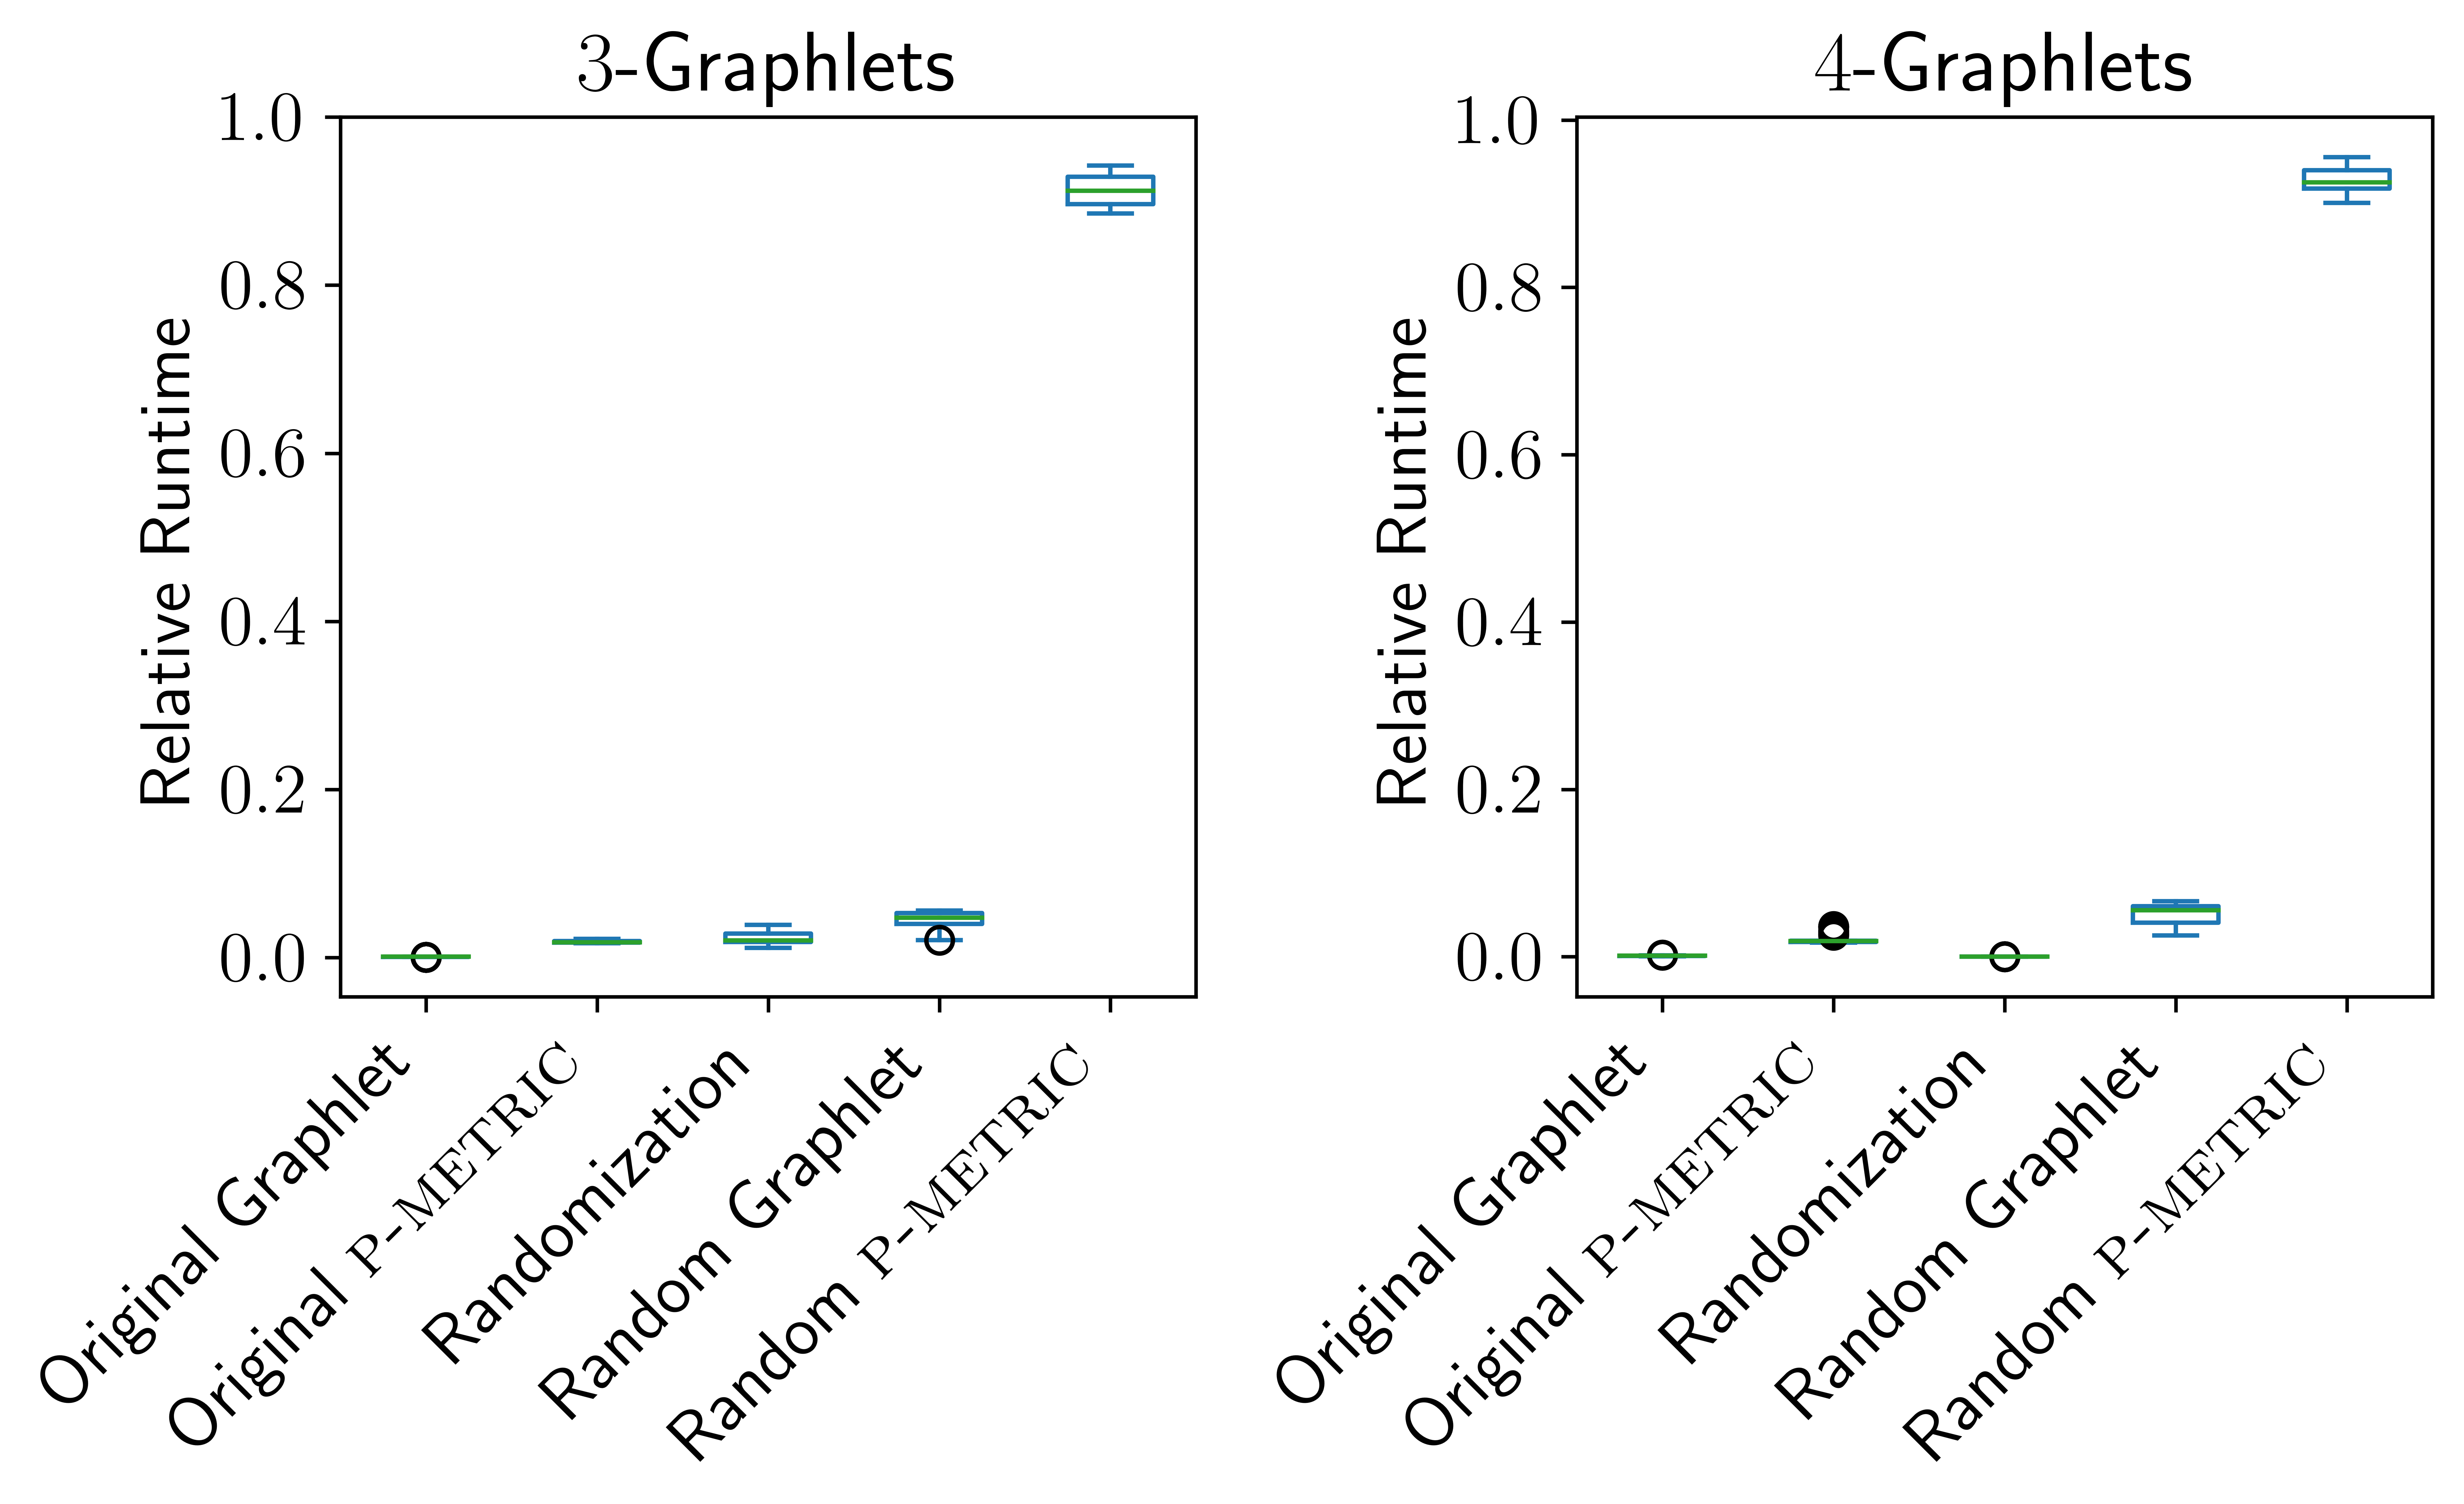

In [16]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['text.usetex'] = True


fig, (ax3, ax4) = plt.subplots(1,2, figsize=(8,5), dpi=1024)

all_percent(3, ax3)
all_percent(4, ax4)

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha="right")
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha="right")


ax3.set_yticks(ax4.get_yticks()[1:-1])


ax3.set_ylabel("Relative Runtime")
ax4.set_ylabel("Relative Runtime")

fig.tight_layout()
fig.show()

In [17]:
fig.savefig("similar_step_runtimes.pdf")

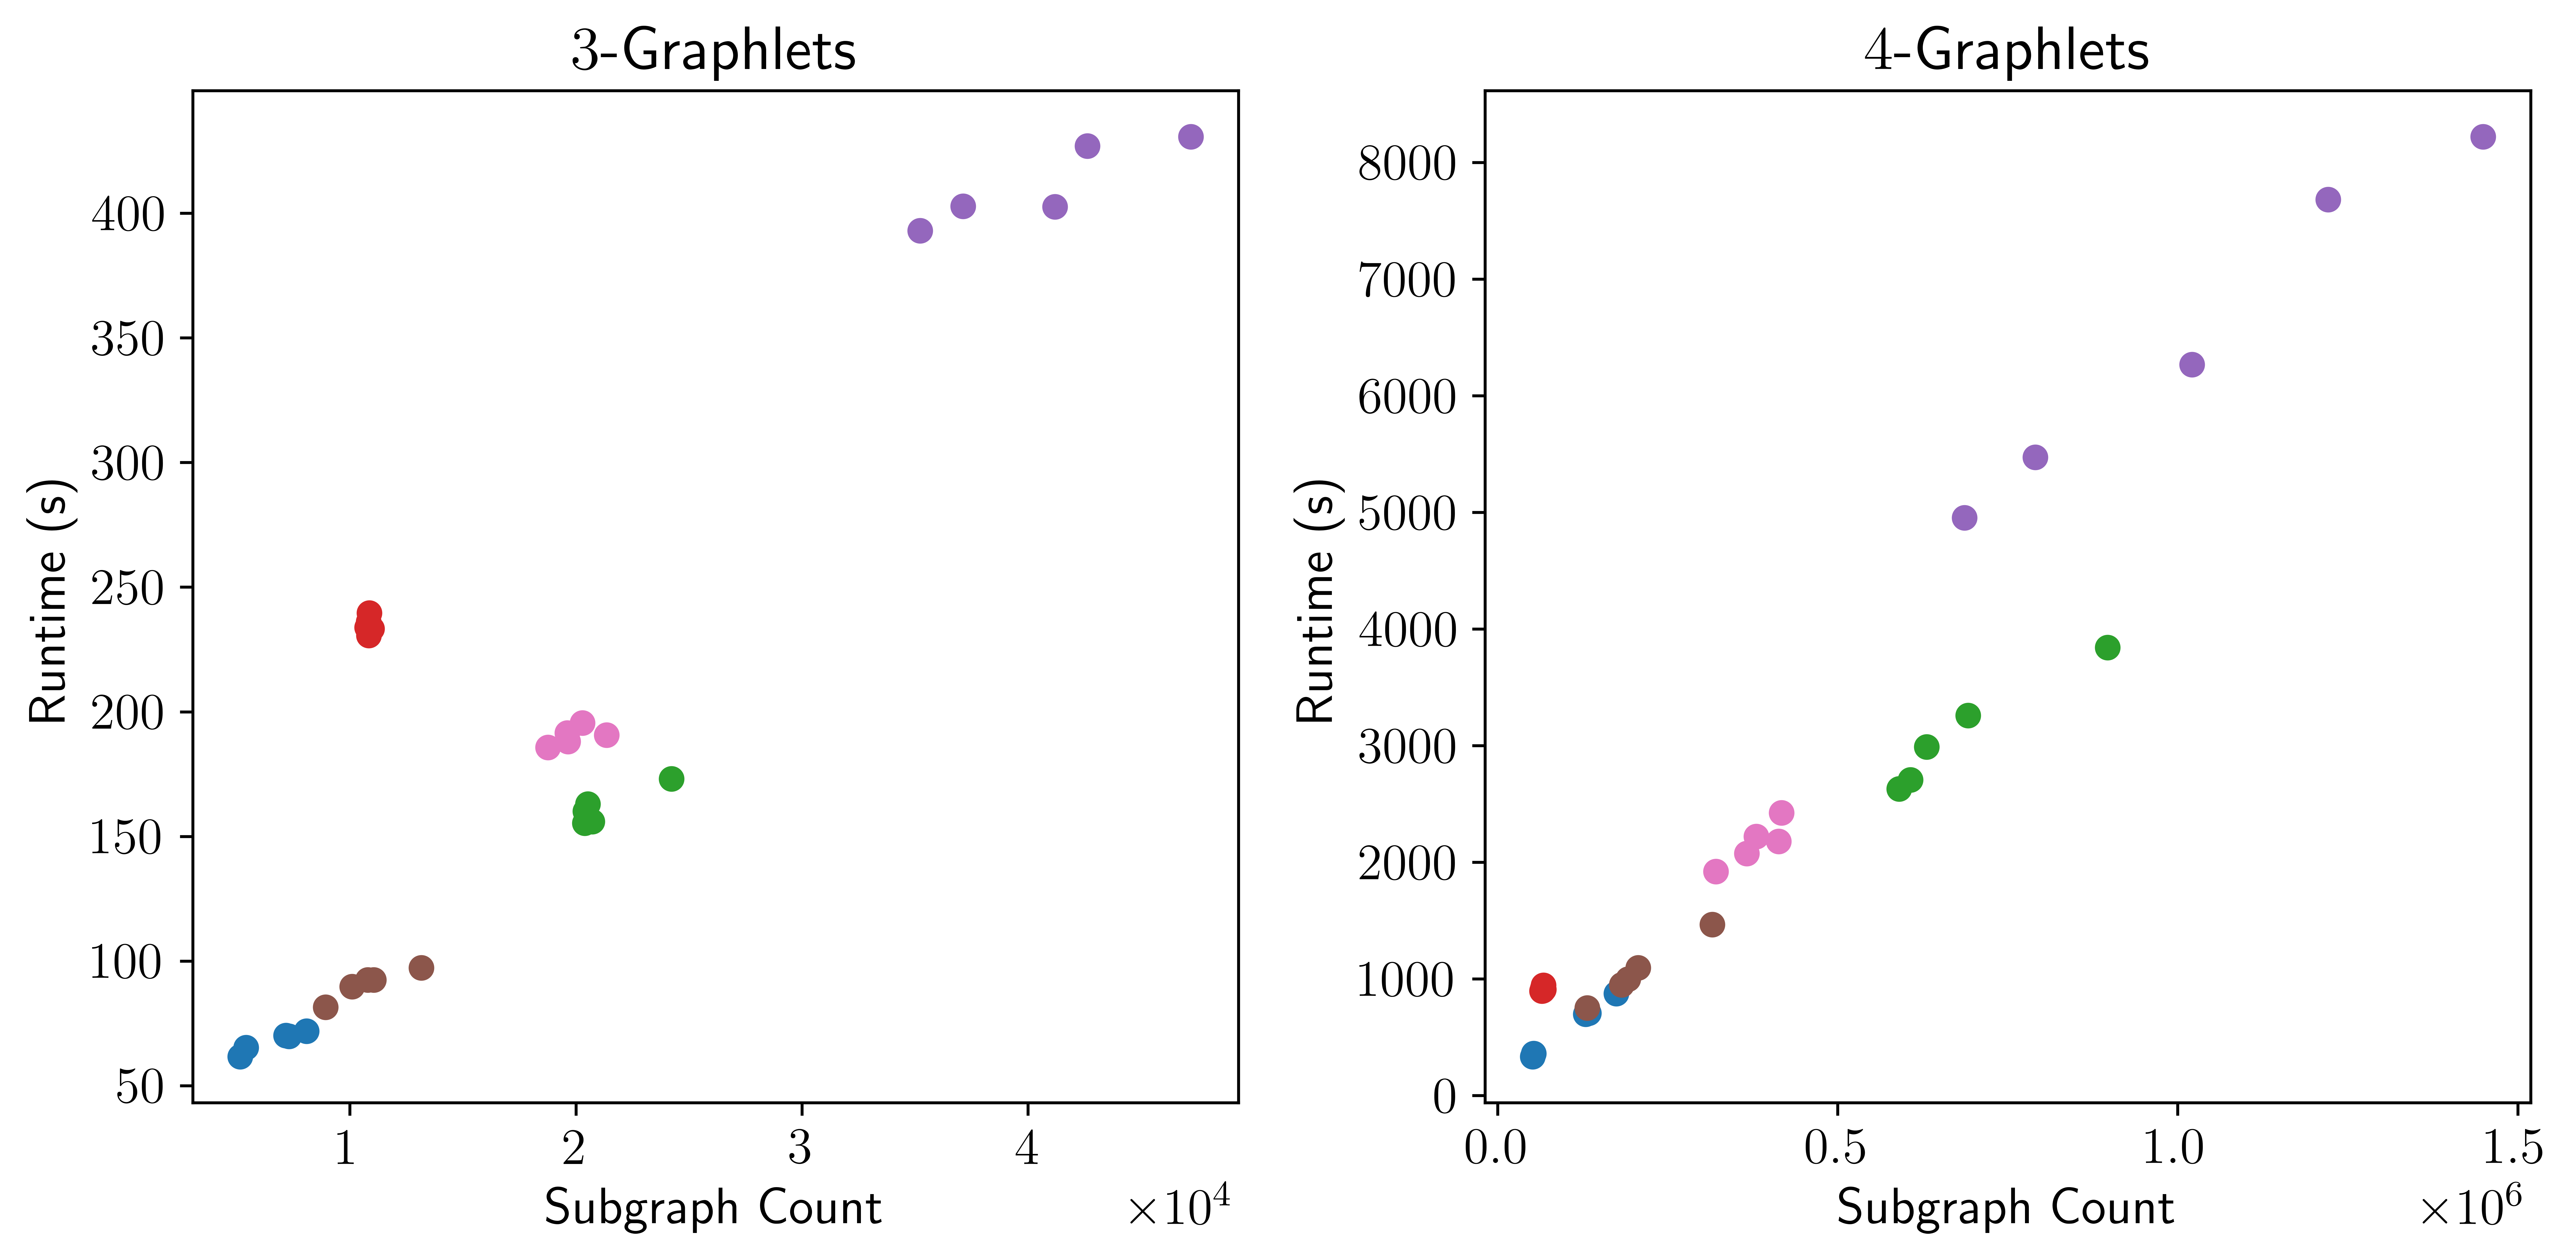

In [75]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


plt.rcParams.update({'font.size': 14})

plt.rcParams['text.usetex'] = True

colors_for_graph_types = {
    'barabasi_albert_graph_m_1': 'tab:blue',
    'scale_free_graph_a_28_b_7_g_02': 'tab:orange',
    'scale_free_graph_a_35_b_3_g_35': 'tab:green',
    'ferdos_renyi_graph_m_2000': 'tab:red',
    'barabasi_albert_graph_m_3': 'tab:purple',
    'scale_free_graph_a_65_b_1_g_25': 'tab:brown',
    'barabasi_albert_graph_m_2': 'tab:pink',
    'brain_development_cutoff_0.772': "tab:grey",
    'cancer_cutoff_0.935' : 'tab:cyan',
 }

SKIP = [
    "scale_free_graph_a_28_b_7_g_02", 
    "brain_development_cutoff_0.772",
    "cancer_cutoff_0.935",
]
SKIP = []

def graph_to_type(name: str):
    number, *rest = name.split("_")
    return "_".join(rest)


fig, (k3, k4) = plt.subplots(1,2, figsize=(10, 5), dpi=1024)


df = get_dataframe(3)
df["graph_type"] = list(map(graph_to_type, df.index))
for gt in set(df["graph_type"]):
    if gt in SKIP:
        continue
    
    subgraph_count = df[df["graph_type"] == gt]["subgraph_count_3"]
    total_runtime = df[df["graph_type"] == gt]["total_runtime"]
    
    k3.scatter(subgraph_count, total_runtime, label=gt, color=colors_for_graph_types[gt])


df = get_dataframe(4)
df["graph_type"] = list(map(graph_to_type, df.index))
for gt in set(df["graph_type"]):
    if gt in SKIP:
        continue
    subgraph_count = df[df["graph_type"] == gt]["subgraph_count_4"]
    total_runtime = df[df["graph_type"] == gt]["total_runtime"]

    k4.scatter(subgraph_count, total_runtime, label=gt, color=colors_for_graph_types[gt])


# Axis
k3.set_xlabel("Subgraph Count")
k4.set_xlabel("Subgraph Count")

k3.set_ylabel("Runtime (s)")
k4.set_ylabel("Runtime (s)")

k3.set_title(r"$3$-Graphlets")
k4.set_title(r"$4$-Graphlets")

k3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
# Legend

import matplotlib.lines as mlines

label_lookup = {
    'barabasi_albert_graph_m_1': r"\textsc{Barabási-Albert} $m_1$",
    'barabasi_albert_graph_m_2': r"\textsc{Barabási-Albert} $m_2$",
    'barabasi_albert_graph_m_3': r"\textsc{Barabási-Albert} $m_3$",
    'ferdos_renyi_graph_m_2000': r"\textsc{Erdős–Rényi}",
    # 'scale_free_graph_a_28_b_7_g_02': r"\textsc{scale-free\textsubscript{28}",
    'scale_free_graph_a_35_b_3_g_35': r"\textsc{scale-free\textsubscript{35}",
    'scale_free_graph_a_65_b_1_g_25': r"\textsc{scale-free\textsubscript{65}",
    # 'brain_development_cutoff_0.772': r"\textsc{Human Brain}",
    # 'cancer_cutoff_0.935' : r"\textsc{Human Cancer}",
}

labels = []
handles = []

for graph_type, tex_label in label_lookup.items():
    if graph_type in SKIP:
        continue
    
    labels.append(tex_label)
    handles.append(
        mlines.Line2D(
            [], [],
            color=colors_for_graph_types[graph_type],
            marker='o',
            linestyle='None',
            markersize=8,
            label=tex_label)
    )
# k3.legend(labels=labels, handles=handles)

# INset
if False:
    axins = k3.inset_axes([0.5, 0.1, 0.47, 0.47])
    # Plot
    df = get_dataframe(3)
    df["graph_type"] = list(map(graph_to_type, df.index))
    for gt in set(df["graph_type"]):
        if gt in SKIP:

            continue
        subgraph_count = df[df["graph_type"] == gt]["subgraph_count_3"]
        total_runtime = df[df["graph_type"] == gt]["total_runtime"]
        axins.scatter(subgraph_count, total_runtime, label=gt, color=colors_for_graph_types[gt])

    # axins.imshow(Z2, extent=extent, origin="lower")
    # subregion of the original image

    k3.indicate_inset([-10**6, 0, 5 * 10 ** 6, 500], axins, edgecolor="black")

fig.tight_layout()

In [66]:
"""Collect subgraph counts to calculate pearson r"""
from scipy.stats import pearsonr

def get_subgraph_count_and_total_runtime(k):
    df = get_dataframe(k)
    return list(df[f"subgraph_count_{k}"]), list(df["total_runtime"])

k = 4
print("k=", k)
print(list(map(len, get_subgraph_count_and_total_runtime(k))))
pearsonr(*get_subgraph_count_and_total_runtime(k))


k= 4
[30, 30]


PearsonRResult(statistic=0.9702376929106586, pvalue=8.73577947268719e-19)

In [19]:
total_runtime

dataset
1_barabasi_albert_graph_m_2    2179.045207
2_barabasi_albert_graph_m_2    2076.340337
4_barabasi_albert_graph_m_2    1921.398154
0_barabasi_albert_graph_m_2    2220.282486
3_barabasi_albert_graph_m_2    2424.123305
Name: total_runtime, dtype: float64

In [20]:
fig.savefig("runtime_scatter.pdf")
fig.savefig("runtime_scatter.png")

In [21]:
df = get_dataframe(3)
df

total_runtime  original_gtrie_runtime   
dataset                                                                   
1_scale_free_graph_a_35_b_3_g_35     173.070969                0.183004  \
1_barabasi_albert_graph_m_2          190.627695                0.182036   
3_barabasi_albert_graph_m_1           71.841488                0.077814   
1_barabasi_albert_graph_m_3          402.597279                0.326034   
2_barabasi_albert_graph_m_2          188.041797                0.166915   
3_ferdos_renyi_graph_m_2000          236.142498                0.091561   
1_ferdos_renyi_graph_m_2000          230.609268                0.093222   
1_scale_free_graph_a_65_b_1_g_25      92.429807                0.093914   
4_barabasi_albert_graph_m_3          392.955247                0.289180   
0_ferdos_renyi_graph_m_2000          239.575862                0.092819   
3_barabasi_albert_graph_m_3          430.690385                0.359871   
4_barabasi_albert_graph_m_2          185.744808                0.165714   
2_barabasi_albert_graph_m_3          426.958308                0.331631   
0_barabasi_albert_graph_m_1           61.674366                0.056655   
3_scale_free_graph_a_65_b_1_g_25      89.755334                0.091803   
2_ferdos_renyi_graph_m_2000          233.287949                0.093268   
0_scale_free_graph_a_35_b_3_g_35     155.334760                0.162879   
0_scale_free_graph_a_65_b_1_g_25      81.450394                0.082107   
4_scale_free_graph_a_35_b_3_g_35     155.967742                0.161977   
3_scale_free_graph_a_35_b_3_g_35     160.112872                0.156036   
0_barabasi_albert_graph_m_3          402.771196                0.302898   
4_scale_free_graph_a_65_b_1_g_25      97.324325                0.104223   
1_barabasi_albert_graph_m_1           70.142544                0.070270   
2_scale_free_graph_a_35_b_3_g_35     162.938260                0.165599   
0_barabasi_albert_graph_m_2          191.434985                0.157131   
3_barabasi_albert_graph_m_2          195.518246                0.173504   
2_barabasi_albert_graph_m_1           69.850375                0.072810   
2_scale_free_graph_a_65_b_1_g_25      92.405739                0.095062   
4_barabasi_albert_graph_m_1           65.276665                0.057878   
4_ferdos_renyi_graph_m_2000          233.787112                0.091802   

                                  original_metric_runtime   
dataset                                                     
1_scale_free_graph_a_35_b_3_g_35                 3.099822  \
1_barabasi_albert_graph_m_2                      3.240829   
3_barabasi_albert_graph_m_1                      1.548821   
1_barabasi_albert_graph_m_3                      7.300272   
2_barabasi_albert_graph_m_2                      3.224774   
3_ferdos_renyi_graph_m_2000                      4.099087   
1_ferdos_renyi_graph_m_2000                      4.082469   
1_scale_free_graph_a_65_b_1_g_25                 1.830487   
4_barabasi_albert_graph_m_3                      6.831130   
0_ferdos_renyi_graph_m_2000                      4.243406   
3_barabasi_albert_graph_m_3                      7.543288   
4_barabasi_albert_graph_m_2                      3.245528   
2_barabasi_albert_graph_m_3                      7.652528   
0_barabasi_albert_graph_m_1                      1.303335   
3_scale_free_graph_a_65_b_1_g_25                 1.694109   
2_ferdos_renyi_graph_m_2000                      4.133260   
0_scale_free_graph_a_35_b_3_g_35                 2.792156   
0_scale_free_graph_a_65_b_1_g_25                 1.591697   
4_scale_free_graph_a_35_b_3_g_35                 2.771374   
3_scale_free_graph_a_35_b_3_g_35                 2.874757   
0_barabasi_albert_graph_m_3                      7.259115   
4_scale_free_graph_a_65_b_1_g_25                 1.876939   
1_barabasi_albert_graph_m_1                      1.538509   
2_scale_free_graph_a_35_b_3_g_35                 2.935868   
0_barabasi_albert_graph_m_2                    

In [22]:
df = get_dataframe(3)

df["Original"] = (df["original_gtrie_runtime"] + df["original_metric_runtime"]) / df["total_runtime"]
df["Random"] = (df["total random_gtrie_runtimes"] + df["total random_metric_runtimes"]) / df["total_runtime"]
df["Randomization"] = (df["random_generation_runtime"]) / df["total_runtime"]
df = df[["Original", "Random", "Randomization"]]
df.head()

Original    Random  Randomization
dataset                                                            
1_scale_free_graph_a_35_b_3_g_35  0.018968  0.963021       0.017660
1_barabasi_albert_graph_m_2       0.017956  0.959643       0.022067
3_barabasi_albert_graph_m_1       0.022642  0.943685       0.032963
1_barabasi_albert_graph_m_3       0.018943  0.968029       0.012855
2_barabasi_albert_graph_m_2       0.018037  0.960527       0.021112

In [23]:
def get_data_of_benchmarkruns(k):
    df = get_dataframe(k)
    df["Original Graphlet"] = df["original_gtrie_runtime"] / df["total_runtime"]
    df[r"Original \textsc{p-metric}"] = df["original_metric_runtime"] / df["total_runtime"]
    df["Randomization"] = df["random_generation_runtime"] / df["total_runtime"]
    df["Random Graphlet"] = df["total random_gtrie_runtimes"] / df["total_runtime"]
    df[r"Random \textsc{p-metric}"] = df["total random_metric_runtimes"] / df["total_runtime"]
    
    df = df[[
        "Original Graphlet",
        r"Original \textsc{p-metric}",
        "Randomization",
        "Random Graphlet",
        r"Random \textsc{p-metric}",
    ]]
    return df

In [24]:
df = get_dataframe(3)
df["Graphlet Detection"] = (df["original_gtrie_runtime"] + df["total random_gtrie_runtimes"]) / df["total_runtime"]
df[r"\textsc{p-metric} Collection"] = (df["original_metric_runtime"] + df["total random_metric_runtimes"]) / df["total_runtime"]
df["Randomization"] = (df["random_generation_runtime"]) / df["total_runtime"]
df = df[["Randomization", "Graphlet Detection", r"\textsc{p-metric} Collection"]]
df.mean()

Randomization                   0.022866
Graphlet Detection              0.044545
\textsc{p-metric} Collection    0.932180
dtype: float64

In [25]:
import networkx as nx

def get_avg_cc(dataset):
    p = Path("/home/timgarrels/MA_analytics/random_graphs/" + dataset)
    g = nx.read_edgelist(p)
    return nx.average_clustering(g)
get_avg_cc(df.index[0])

0.01841350353456252

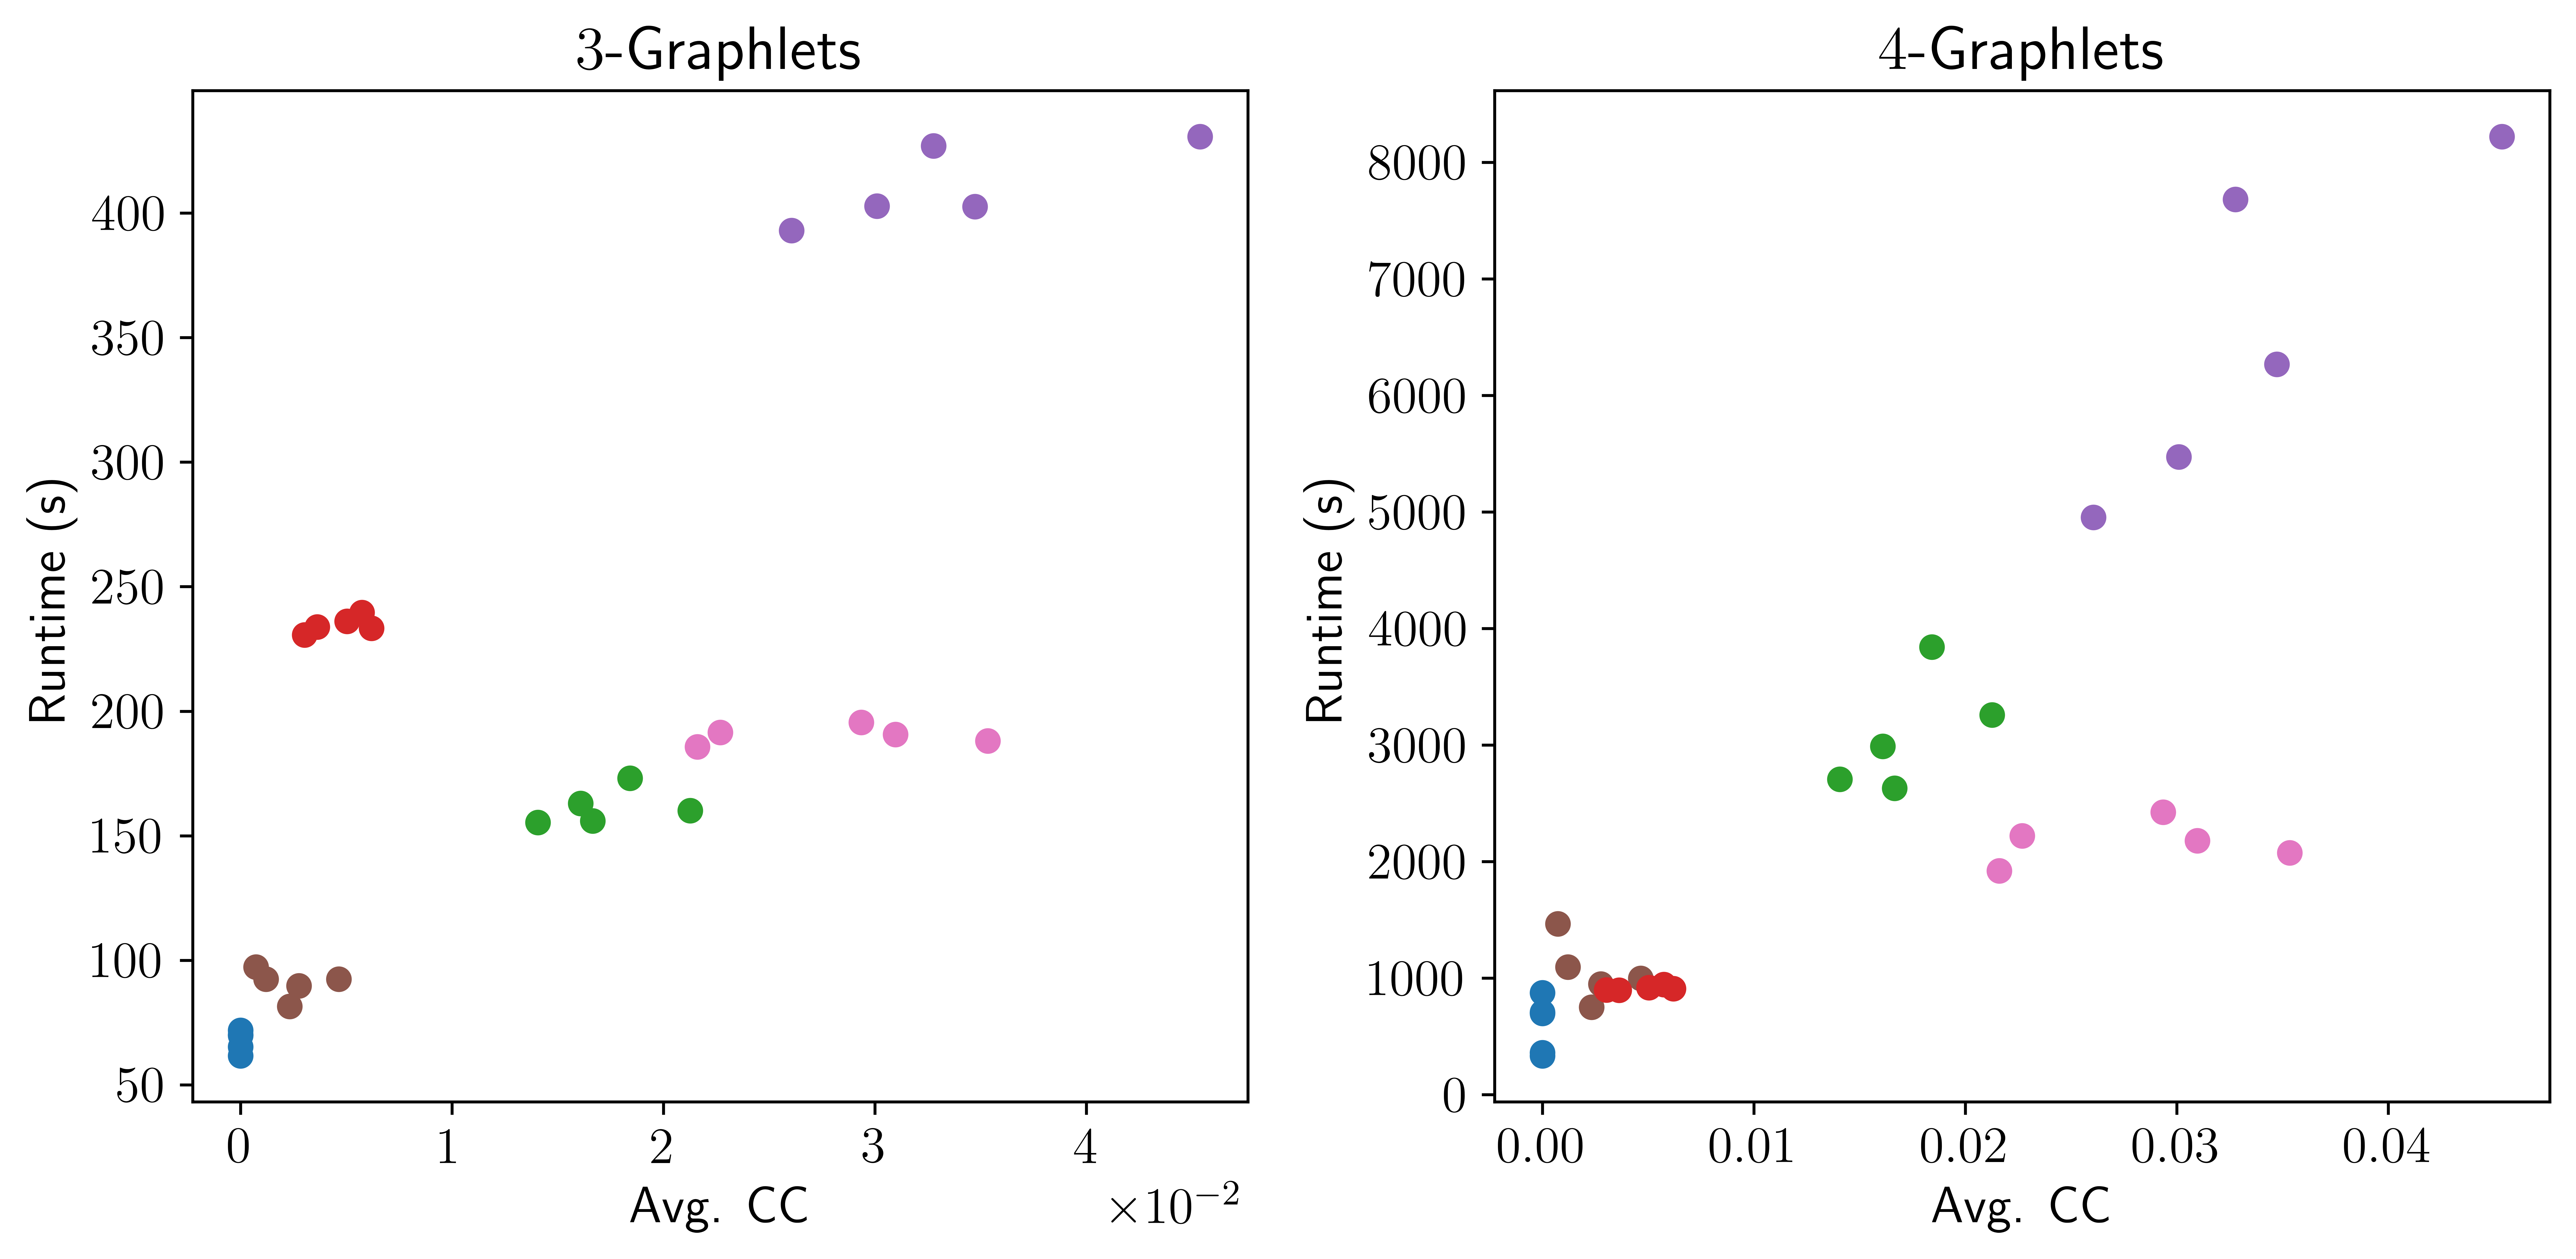

In [73]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams.update({'font.size': 14})

plt.rcParams['text.usetex'] = True

colors_for_graph_types = {
    'barabasi_albert_graph_m_1': 'tab:blue',
    'scale_free_graph_a_28_b_7_g_02': 'tab:orange',
    'scale_free_graph_a_35_b_3_g_35': 'tab:green',
    'ferdos_renyi_graph_m_2000': 'tab:red',
    'barabasi_albert_graph_m_3': 'tab:purple',
    'scale_free_graph_a_65_b_1_g_25': 'tab:brown',
    'barabasi_albert_graph_m_2': 'tab:pink',
    'brain_development_cutoff_0.772': "tab:grey",
    'cancer_cutoff_0.935' : 'tab:cyan',
 }

SKIP = [
    "scale_free_graph_a_28_b_7_g_02", 
    "brain_development_cutoff_0.772",
    "cancer_cutoff_0.935",
]
SKIP = []

def graph_to_type(name: str):
    number, *rest = name.split("_")
    return "_".join(rest)


fig, (k3, k4) = plt.subplots(1,2, figsize=(10, 5), dpi=1024)


df = get_dataframe(3)
df["avg_cc"] = df.index.map(get_avg_cc)
df["graph_type"] = list(map(graph_to_type, df.index))
for gt in set(df["graph_type"]):
    if gt in SKIP:
        continue
    
    subgraph_count = df[df["graph_type"] == gt]["subgraph_count_3"]
    avg_cc = df[df["graph_type"] == gt]["avg_cc"]
    total_runtime = df[df["graph_type"] == gt]["total_runtime"]
    k3.scatter(avg_cc, total_runtime, label=gt, color=colors_for_graph_types[gt])

df = get_dataframe(4)
df["avg_cc"] = df.index.map(get_avg_cc)
df["graph_type"] = list(map(graph_to_type, df.index))
for gt in set(df["graph_type"]):
    if gt in SKIP:
        continue
    subgraph_count = df[df["graph_type"] == gt]["subgraph_count_4"]
    avg_cc = df[df["graph_type"] == gt]["avg_cc"]
    total_runtime = df[df["graph_type"] == gt]["total_runtime"]
    k4.scatter(avg_cc, total_runtime, label=gt, color=colors_for_graph_types[gt])

# Axis
k3.set_xlabel("Avg. CC")
k4.set_xlabel("Avg. CC")

k3.set_ylabel("Runtime (s)")
k4.set_ylabel("Runtime (s)")

k3.set_title(r"$3$-Graphlets")
k4.set_title(r"$4$-Graphlets")

k3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
# Legend

import matplotlib.lines as mlines

label_lookup = {
    'barabasi_albert_graph_m_1': r"\textsc{Barabási-Albert} $m_1$",
    'barabasi_albert_graph_m_2': r"\textsc{Barabási-Albert} $m_2$",
    'barabasi_albert_graph_m_3': r"\textsc{Barabási-Albert} $m_3$",
    'ferdos_renyi_graph_m_2000': r"\textsc{Erdős–Rényi}",
    # 'scale_free_graph_a_28_b_7_g_02': r"\textsc{scale-free\textsubscript{28}",
    'scale_free_graph_a_35_b_3_g_35': r"\textsc{scale-free\textsubscript{35}",
    'scale_free_graph_a_65_b_1_g_25': r"\textsc{scale-free\textsubscript{65}",
    # 'brain_development_cutoff_0.772': r"\textsc{Human Brain}",
    # 'cancer_cutoff_0.935' : r"\textsc{Human Cancer}",
}

labels = []
handles = []

for graph_type, tex_label in label_lookup.items():
    if graph_type in SKIP:
        continue
    
    labels.append(tex_label)
    handles.append(
        mlines.Line2D(
            [], [],
            color=colors_for_graph_types[graph_type],
            marker='o',
            linestyle='None',
            markersize=8,
            label=tex_label)
    )
# k3.legend(labels=labels, handles=handles)
fig.tight_layout()

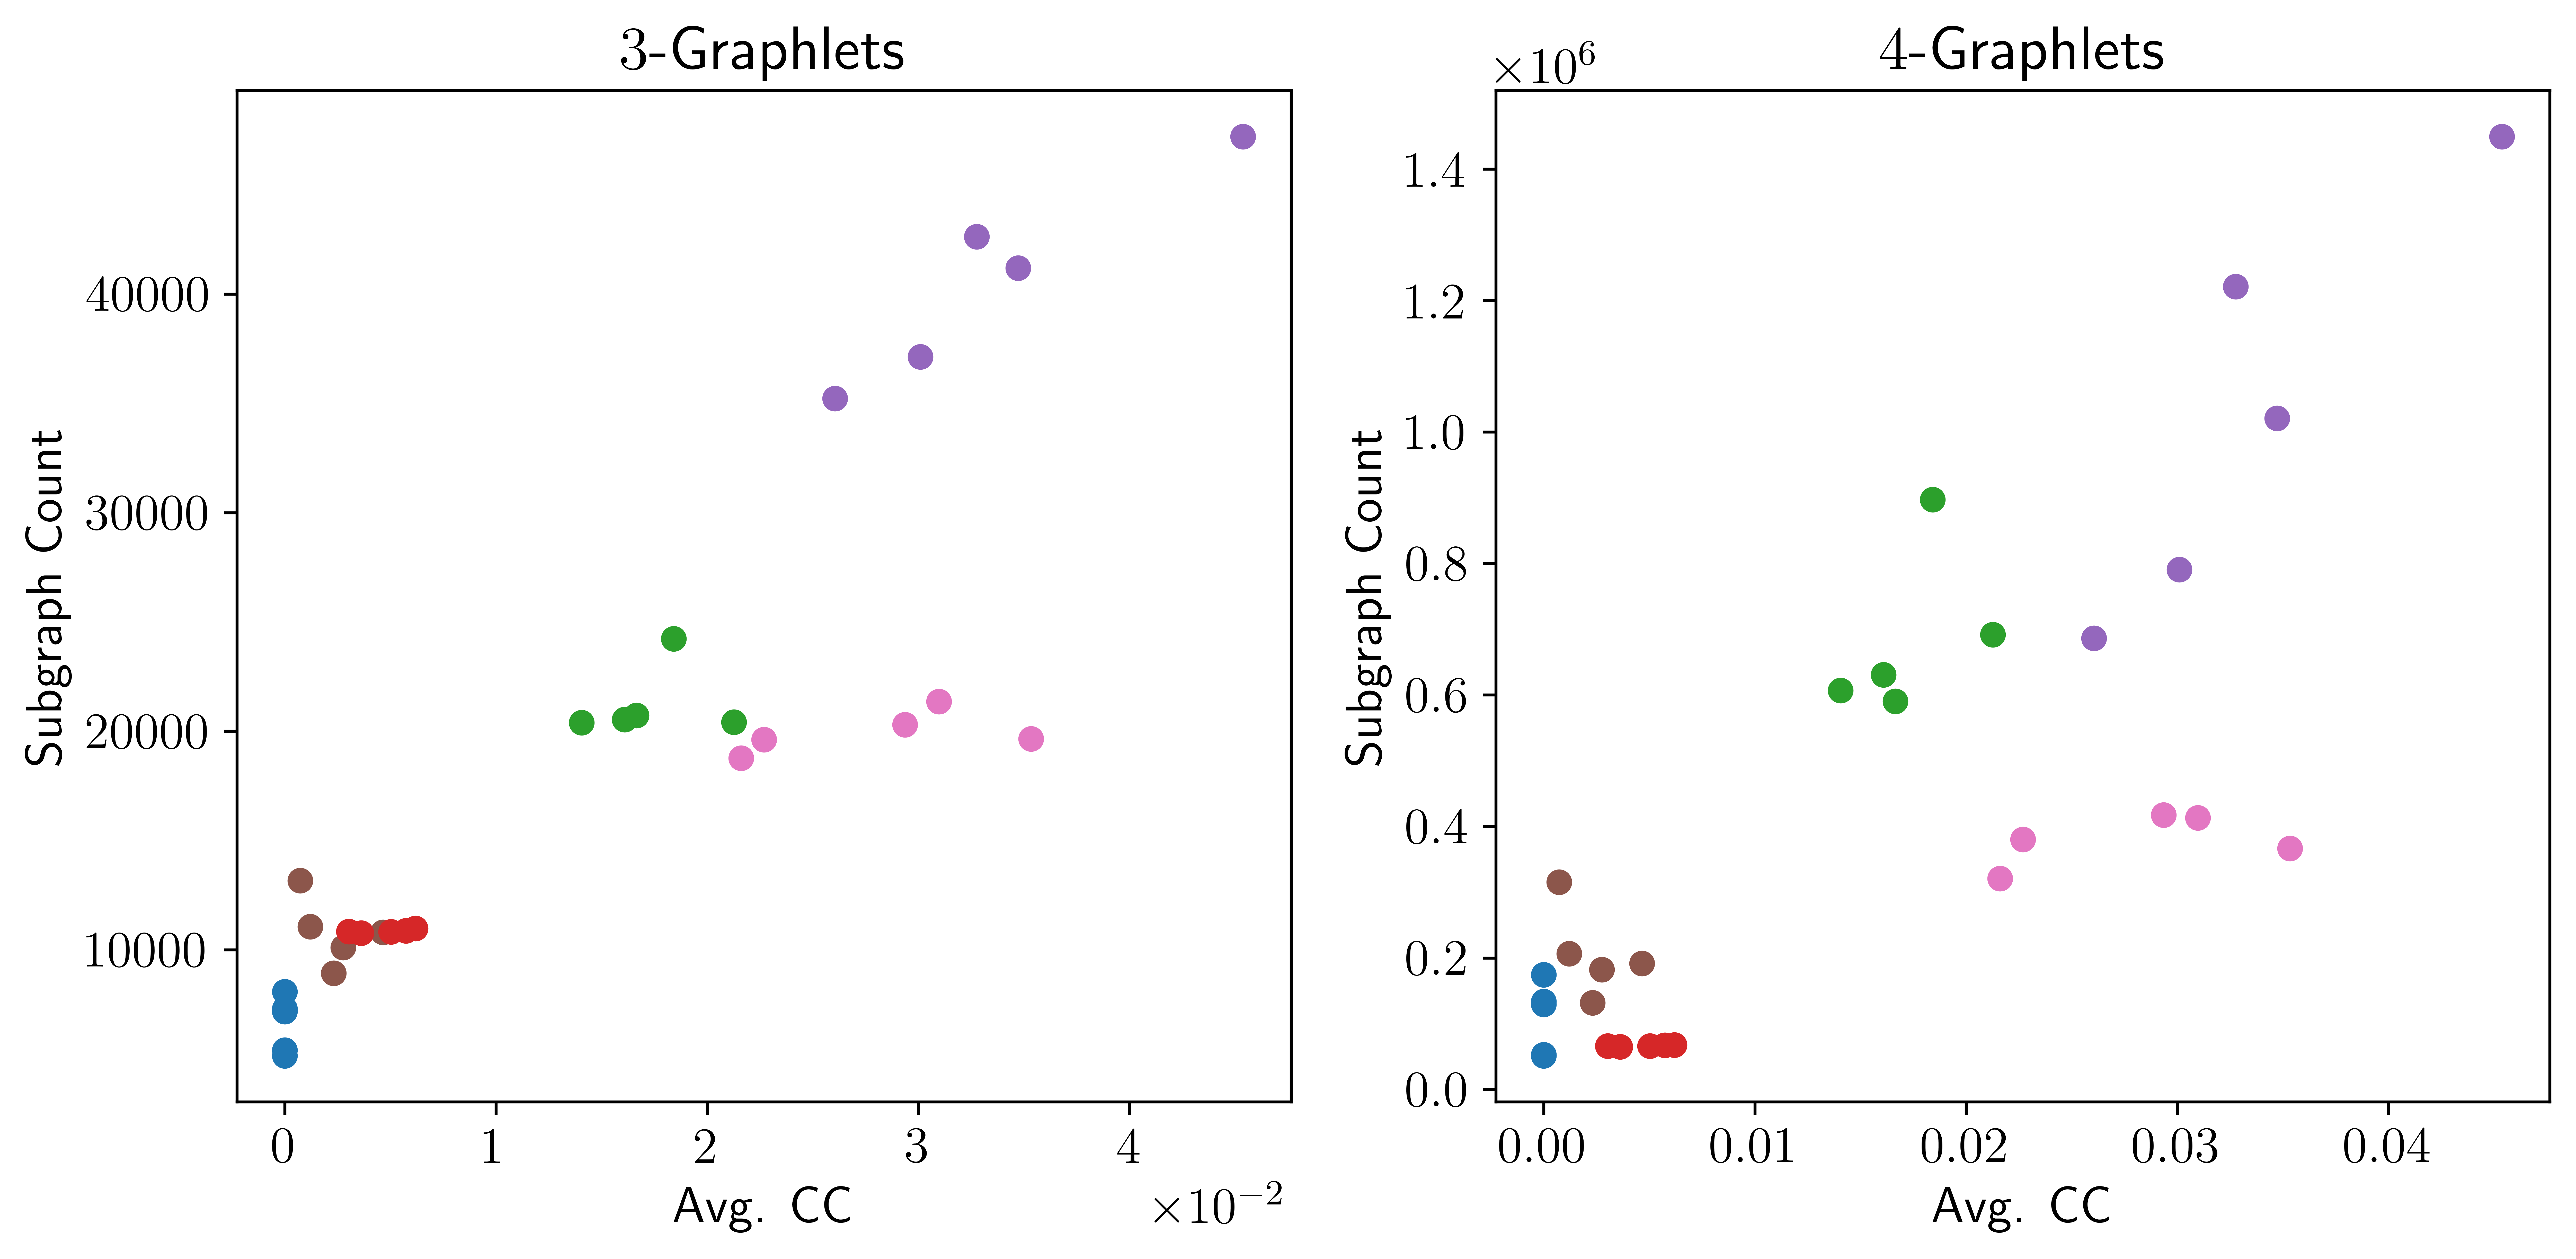

In [74]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams.update({'font.size': 14})

plt.rcParams['text.usetex'] = True

colors_for_graph_types = {
    'barabasi_albert_graph_m_1': 'tab:blue',
    'scale_free_graph_a_28_b_7_g_02': 'tab:orange',
    'scale_free_graph_a_35_b_3_g_35': 'tab:green',
    'ferdos_renyi_graph_m_2000': 'tab:red',
    'barabasi_albert_graph_m_3': 'tab:purple',
    'scale_free_graph_a_65_b_1_g_25': 'tab:brown',
    'barabasi_albert_graph_m_2': 'tab:pink',
    'brain_development_cutoff_0.772': "tab:grey",
    'cancer_cutoff_0.935' : 'tab:cyan',
 }

SKIP = [
    "scale_free_graph_a_28_b_7_g_02", 
    "brain_development_cutoff_0.772",
    "cancer_cutoff_0.935",
]
SKIP = []

def graph_to_type(name: str):
    number, *rest = name.split("_")
    return "_".join(rest)


fig, (k3, k4) = plt.subplots(1,2, figsize=(10, 5), dpi=1024)


df = get_dataframe(3)
df["avg_cc"] = df.index.map(get_avg_cc)
df["graph_type"] = list(map(graph_to_type, df.index))
for gt in set(df["graph_type"]):
    if gt in SKIP:
        continue
    
    subgraph_count = df[df["graph_type"] == gt]["subgraph_count_3"]
    avg_cc = df[df["graph_type"] == gt]["avg_cc"]
    total_runtime = df[df["graph_type"] == gt]["total_runtime"]
    k3.scatter(avg_cc, subgraph_count, label=gt, color=colors_for_graph_types[gt])

df = get_dataframe(4)
df["avg_cc"] = df.index.map(get_avg_cc)
df["graph_type"] = list(map(graph_to_type, df.index))
for gt in set(df["graph_type"]):
    if gt in SKIP:
        continue
    subgraph_count = df[df["graph_type"] == gt]["subgraph_count_4"]
    avg_cc = df[df["graph_type"] == gt]["avg_cc"]
    total_runtime = df[df["graph_type"] == gt]["total_runtime"]
    k4.scatter(avg_cc, subgraph_count, label=gt, color=colors_for_graph_types[gt])

# Axis
k3.set_xlabel("Avg. CC")
k4.set_xlabel("Avg. CC")

k3.set_ylabel("Subgraph Count")
k4.set_ylabel("Subgraph Count")

k3.set_title(r"$3$-Graphlets")
k4.set_title(r"$4$-Graphlets")

k3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
# Legend

import matplotlib.lines as mlines

label_lookup = {
    'barabasi_albert_graph_m_1': r"\textsc{Barabási-Albert} $m_1$",
    'barabasi_albert_graph_m_2': r"\textsc{Barabási-Albert} $m_2$",
    'barabasi_albert_graph_m_3': r"\textsc{Barabási-Albert} $m_3$",
    'ferdos_renyi_graph_m_2000': r"\textsc{Erdős–Rényi}",
    # 'scale_free_graph_a_28_b_7_g_02': r"\textsc{scale-free\textsubscript{28}",
    'scale_free_graph_a_35_b_3_g_35': r"\textsc{scale-free\textsubscript{35}",
    'scale_free_graph_a_65_b_1_g_25': r"\textsc{scale-free\textsubscript{65}",
    # 'brain_development_cutoff_0.772': r"\textsc{Human Brain}",
    # 'cancer_cutoff_0.935' : r"\textsc{Human Cancer}",
}

labels = []
handles = []

for graph_type, tex_label in label_lookup.items():
    if graph_type in SKIP:
        continue
    
    labels.append(tex_label)
    handles.append(
        mlines.Line2D(
            [], [],
            color=colors_for_graph_types[graph_type],
            marker='o',
            linestyle='None',
            markersize=8,
            label=tex_label)
    )
# k3.legend(labels=labels, handles=handles)

fig.tight_layout()

In [28]:
fig.savefig("benchmark_avg_cc_subgraph_count.png")

In [72]:
k = 4

df = get_dataframe(k)
df["avg_cc"] = df.index.map(get_avg_cc)
subgraph_count = df[f"subgraph_count_{k}"]
avg_cc = df["avg_cc"]

print("k=", k)
print(list(map(len, [subgraph_count, avg_cc])))
pearsonr(subgraph_count, avg_cc)

k= 4
[30, 30]


PearsonRResult(statistic=0.8191132927532083, pvalue=3.1334396616528986e-08)